# Study of UK population dynamics

## Introduction
In this document I will analyze  evolution of UK population accross:
* Time
* Region
* Gender
* Age

## Data Loading
First of all, I trasform data collected from the given url into a "tidy" dataframe where
* Each variable forms a column
* Each observation forms a row
* Each measure forms a dataframe
* There is not "Total" element and dimensions elements are partition of the total


In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
url="https://www.nomisweb.co.uk/api/v01/dataset/NM_31_1.jsonstat.json"
r = requests.get(url)
data_json = json.loads(r.content.decode())
size=data_json['size']  

In [3]:
#initialize empty columns
time=[]
region=[]
gender=[]
age=[]
meas=[]

In [4]:
# create every column separately to have better performances
for time_index in range(size[0]):
    time=time+[list(data_json['dimension']['time']['category']['label'].
                    values())[time_index]]*size[1]*size[2]*size[3]*size[4]
    for geo_index in range(size[1]):
        region=region+[list(data_json['dimension']['geography']['category']['label'].
                            values())[geo_index]]*size[2]*size[3]*size[4]
        for sex_index in range(size[2]):
            gender=gender+[list(data_json['dimension']['sex']['category']['label'].
                                values())[sex_index]]*size[3]*size[4]
            for age_index in range(size[3]):
                age=age+[list(data_json['dimension']['age']['category']['label'].
                              values())[age_index]]*size[4]
                for meas_index in range(size[4]):
                    meas=meas+[list(data_json['dimension']['measures']['category']
                                    ['label'].values())[meas_index]]

In [5]:
#create the complete DataFrame from json
data_df=pd.DataFrame(
    {'Year':time,
     'Region':region,
     'Gender':gender,
     'Age':age,
     'Measure':meas,
     'Value':data_json['value']}
)

In [6]:
#delete "Total" values and all elements that 
#do not create a partition like "Aged 16 - 59/64"
df_stage1=data_df[
    (data_df.Age!="All ages") & 
    (data_df.Age!="Aged 16 - 59/64") &
    (data_df.Age!="Aged 18 - 24") &
    (data_df.Age!="Aged 16 - 64") &
    (data_df.Age!="Aged 0 - 15") &
    (data_df.Age!="Aged 65 and over") &
    (data_df.Gender!="Total") &
    (data_df.Measure=="Value")
][['Year','Region','Gender','Age','Value']]
df_stage1=df_stage1.dropna() #remove NAN rows of NI from 1981 to 1991
df_stage1['Value']=df_stage1['Value'].astype(int)
df_stage1['Year']=df_stage1['Year'].astype(int)

#create the England data by subtracting "Wales" from "England and Wales"
df_wales=df_stage1[df_stage1.Region=="Wales"]
df_engl_wales=df_stage1[df_stage1.Region=="England and Wales"]
df_engl=pd.merge(df_wales,df_engl_wales,on=["Year","Gender","Age"],how="inner")
df_engl['Value']=df_engl["Value_y"]-df_engl["Value_x"]
df_engl["Region"]="England"
df_engl=df_engl[["Year","Region","Gender","Age","Value"]]
df_pop=pd.concat([df_stage1[df_stage1.Region!="England and Wales"],df_engl])

#new age binning
df_pop=df_pop.replace(df_pop.Age.unique(),
                      ["Aged 0-24"]*6+["Aged 25-50"]*5+
                      ["Aged 51-74"]*5+["Aged 75+"]*3
                     )
df_pop.head()

,Year,Region,Gender,Age,Value
2,1981,Wales,Male,Aged 0-24,18300
4,1981,Wales,Male,Aged 0-24,70200
6,1981,Wales,Male,Aged 0-24,95300
8,1981,Wales,Male,Aged 0-24,113500
10,1981,Wales,Male,Aged 0-24,118700


## Data Exploration
Starting from the created dataframe, I study the population progression by the following dimensions:
* Number of people
* Geographic distribution
* Age distribution
### Table with gender distribution in the last year
As requested I created a dataframe showing male, female and total population in columns, per UK region in rows, as
well as the UK total, for the most recent year.

In [8]:
most_recent_year=df_pop.Year.max() #compute the most recent year
df_pop_ry=df_pop[df_pop.Year==most_recent_year].groupby(
    ['Region','Gender']).sum().reset_index()
df_pop_ry=df_pop_ry.pivot_table(
    index='Region', columns='Gender', values='Value',aggfunc='sum',margins=True)
df_pop_ry

Gender,Female,Male,All
Region,,,
England,28138500,27481400,55619900
Northern Ireland,950500,920400,1870900
Scotland,2784800,2640400,5425200
Wales,1584900,1540100,3125000
All,33458700,32582300,66041000


### Number of people analysis
I analize the number of people trend from 1991 to 2017 because we do not have data of Northern Ireland before 1991.

In [9]:
df_pop_np=df_pop[df_pop.Year>1991].groupby(
    ['Year','Region']).sum().reset_index()
df_pop_np=df_pop_np.pivot_table(
    index='Year',columns='Region', values='Value',aggfunc='sum',margins=False)
df_pop_np.head()

Region,England,Northern Ireland,Scotland,Wales
Year,,,,
1992,47998000,1623400,5085500,2877500
1993,48102700,1635800,5092400,2883400
1994,48228700,1643500,5102400,2887600
1995,48383400,1649100,5104000,2888600
1996,48519100,1661800,5092400,2891200


In [10]:
pop_increase_rate=(df_pop_np.sum(axis=1)[2017]-df_pop_np.sum(axis=1)[2012])/5
pop_increase_rate

467180.0

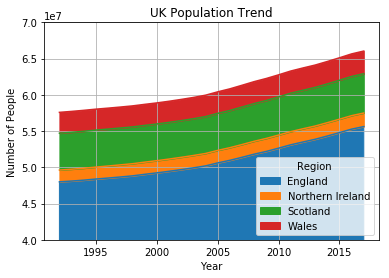

In [11]:
df_pop_np.plot(kind="area")
plt.ylabel("Number of People")
plt.title("UK Population Trend")
plt.ylim([40000000,70000000])
plt.grid()
plt.savefig('np.png')

### Region analysis
I analize the percentage of people in each region from 1991 to 2017.

In [12]:
df_pop_reg=pd.merge(
    df_pop[df_pop.Year>1991].groupby(['Year','Region']).sum().reset_index(),
    df_pop[df_pop.Year>1991].groupby(['Year']).sum().reset_index(),
    on='Year',
    how='inner'
)
df_pop_reg['Percentage']=df_pop_reg.Value_x/df_pop_reg.Value_y*100
df_pop_reg=df_pop_reg.pivot_table(
    index='Year',columns='Region', values='Percentage',aggfunc='sum',margins=False)
df_pop_reg.head()


Region,England,Northern Ireland,Scotland,Wales
Year,,,,
1992,83.352436,2.819166,8.831385,4.997013
1993,83.346242,2.834306,8.823463,4.995989
1994,83.350961,2.840369,8.818192,4.990477
1995,83.383570,2.842046,8.796193,4.978190
1996,83.417033,2.857069,8.755169,4.970730


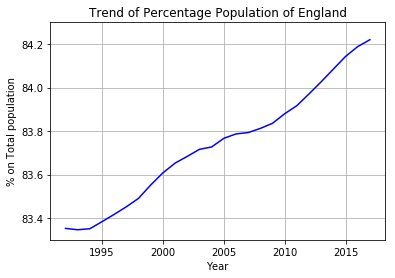

In [13]:
df_pop_reg['England'].plot(kind="line",color="blue")
plt.ylabel("% on Total population")
plt.title("Trend of Percentage Population of England")
plt.ylim([83.3,84.3]) #same scale for every chart (1%)
plt.grid()
plt.savefig('reg1.png')

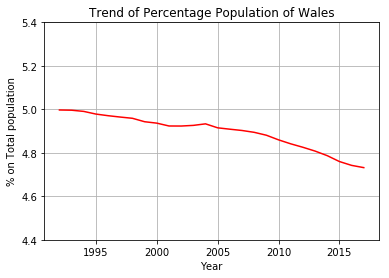

In [14]:
df_pop_reg['Wales'].plot(kind="line",color="red")
plt.ylabel("% on Total population")
plt.title("Trend of Percentage Population of Wales")
plt.ylim([4.4,5.4]) #same scale for every chart (1%)
plt.grid()
plt.savefig('reg2.png')

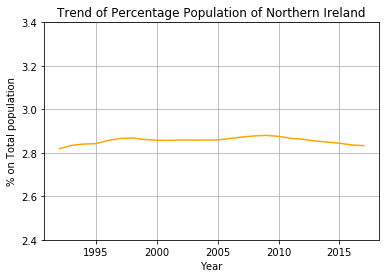

In [15]:
df_pop_reg['Northern Ireland'].plot(kind="line",color="orange")
plt.ylabel("% on Total population")
plt.title("Trend of Percentage Population of Northern Ireland")
plt.ylim([2.4,3.4]) #same scale for every chart (1%)
plt.grid()
plt.savefig('reg3.png')

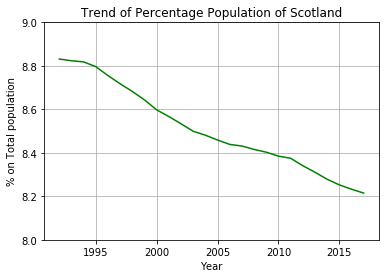

In [16]:
df_pop_reg['Scotland'].plot(kind="line",color="green")
plt.ylabel("% on Total population")
plt.title("Trend of Percentage Population of Scotland")
plt.ylim([8,9]) #same scale for every chart (1%)
plt.grid()
plt.savefig('reg4.png')

### Region analysis
I analize the percentage of people in the group 0-25/ 25-50/ 50-75/ 75+ from 1991 to 2017.

In [17]:
df_pop_age_abs=df_pop[df_pop.Year>1991].pivot_table(
    index='Year',columns='Age', values='Value',aggfunc='sum',margins=False)
df_pop_age_abs.head()

Age,Aged 0-24,Aged 25-50,Aged 51-74,Aged 75+
Year,,,,
1992,19026200,20579800,13982800,3995600
1993,18881400,20751500,14119700,3961700
1994,18753000,20910100,14272200,3926900
1995,18644300,21045000,14275700,4060100
1996,18513300,21178300,14316000,4156900


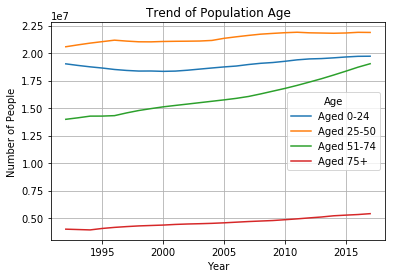

In [18]:
df_pop_age_abs.plot(kind="line")
plt.ylabel("Number of People")
plt.title("Trend of Population Age")
plt.grid()
plt.savefig('age1.png')

In [19]:
df_pop_perc=pd.merge(
    df_pop[df_pop.Year==2017].groupby(['Year','Age','Region']).sum().reset_index(),
    df_pop[df_pop.Year==2017].groupby(['Year','Region']).sum().reset_index(),
    on=['Year','Region'],
    how='inner'
)
df_pop_perc['Percentage']=df_pop_perc.Value_x/df_pop_perc.Value_y*100
df_pop_perc=df_pop_perc.pivot_table(
    index='Region',columns='Age', values='Percentage',aggfunc='sum',margins=False)
df_pop_perc

Age,Aged 0-24,Aged 25-50,Aged 51-74,Aged 75+
Region,,,,
England,30.017134,33.305526,28.523065,8.154276
Northern Ireland,32.107542,32.968090,27.729970,7.194398
Scotland,27.847821,32.931505,30.961071,8.259603
Wales,29.190400,30.499200,31.142400,9.168000


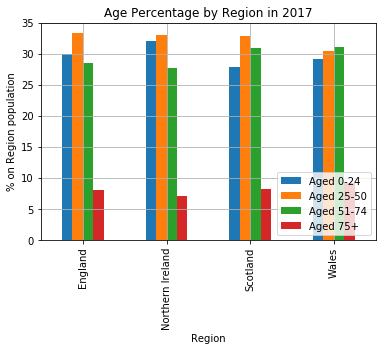

In [20]:
df_pop_perc.plot(kind="bar")
plt.ylabel("% on Region population")
plt.title("Age Percentage by Region in 2017")
plt.grid()
plt.legend(loc="lower right")
plt.savefig('age2.png')